This notebook build a basis chatbot with Langraph (Graph API)

In [78]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.graph.message import add_messages
# add_messages -> reducers (this type the state keys are appended and not overwritten) 

In [79]:
class State(TypedDict):
    messages:Annotated[list, add_messages] # The messages are added to a list




In [80]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [81]:
# from langchain_groq import ChatGroq
# llm = ChatGroq(model='llama3-8b-8192')

In [82]:
from langchain.chat_models import init_chat_model
llm = init_chat_model(model="groq:llama3-8b-8192")

In [83]:
# functionality of the node
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [84]:
graph_builder = StateGraph(State)

In [85]:
# Adding nodes
graph_builder.add_node("chatbot", chatbot)

# Adding edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph=graph_builder.compile()

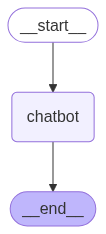

In [86]:
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [87]:
graph.invoke({"messages":"Hi"})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='6c347758-dddf-4cad-94cd-7a8e67fc86ee'),
  AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.020061464, 'prompt_time': 0.002077581, 'queue_time': 0.269986092, 'total_time': 0.022139045}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6d1c2b0784', 'finish_reason': 'stop', 'logprobs': None}, id='run--ea8e7c77-16e3-4a4f-bcc0-b2a8efb33102-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}

In [88]:
# HumanMessage, AIMessage - Annotations

In [89]:
response = graph.invoke({"messages":"Hi"})

In [90]:
response['messages'][-1].content

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [91]:
for event in graph.stream({"messages": "How are you?"}):
    for value in event.values(): 
        print(value["messages"][-1].content)

I'm just a language model, I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! Is there something specific you'd like to chat about or ask?


In [92]:
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tool.invoke("Explain about langgraph vs lsngchain")


{'query': 'Explain about langgraph vs lsngchain',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangChain vs LangGraph: Key Differences Explained - Simplilearn',
   'url': 'https://www.simplilearn.com/langchain-vs-langgraph-article',
   'content': 'LangGraph picks up where LangChain leaves off, itâ\x80\x99s made for situations where your app needs to manage complex flows, not just run a straight line of steps. LangSmith is what you bring in when your LLM app is getting real, itâ\x80\x99s a dev platform for debugging, testing, and monitoring everything you build with LangChain (or LangGraph). | LangChain | Chaining LLM calls, prompts, memory, and tools | Building full-featured LLM apps with structured flows | Yes | Yes | | LangFlow | Visual interface for building LangChain apps with no/low code | Prototyping, testing ideas quickly, MVPs without writing much code | No | Not ideal for production | When it comes to building with LLMs, thereâ\x80\x99s

In [93]:
def customerfunction(a:int, b:int)->int:
    """multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int      
    """
    return a*b

In [94]:
tools=[tool,customerfunction]

In [95]:
llm_with_tools=llm.bind_tools(tools)

In [96]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

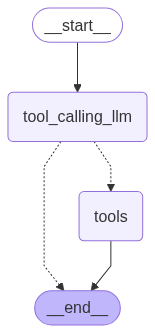

In [97]:
# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message which is the result is a tool call -> tool_condition routes to tool, else routes to end
    tools_condition
)
builder.add_edge("tools", END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [98]:
graph.invoke({"messages":"What is a recent ai news of Langgraph"})

{'messages': [HumanMessage(content='What is a recent ai news of Langgraph', additional_kwargs={}, response_metadata={}, id='2950044d-ea4b-49d0-8a98-d62cfbc211e8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'w8wpjvf7m', 'function': {'arguments': '{"query":"recent AI news Langgraph","search_depth":"advanced","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 2266, 'total_tokens': 2359, 'completion_time': 0.074483227, 'prompt_time': 0.255488489, 'queue_time': 0.274875212, 'total_time': 0.329971716}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c134e4f6-bc37-4237-9c34-67149cce619f-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news Langgraph', 'search_depth': 'advanced', 'topic': 'general'}, 'id': 'w8wpjvf7m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2

In [99]:
response=graph.invoke({"messages":"What is a recent ai news of Langgraph"})

In [100]:
response["messages"][-1].content

'{"query": "langraph ai recent news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://changelog.langchain.com/", "title": "LangChain - Changelog", "content": "June 18, 2025 · LangGraph. LangGraph Workflow Updates (Python & JS). We\'ve rolled out a batch of new features across both LangGraph.js and LangGraph for Python", "score": 0.73642004, "raw_content": null}, {"url": "https://github.com/langchain-ai/langgraph/releases", "title": "Releases · langchain-ai/langgraph - GitHub", "content": "### 1. A leaner, stricter StateGraph\\n\\n`state_schema` is now mandatory.\\n\\n`state_schema`\\n\\n“Untyped” graphs were never shown in the docs and produced surprising runtime errors. Requiring an explicit schema fixes that class of bugs and improves static analysis.\\n\\n`input`/`output` → `input_schema`/`output_schema`\\n\\n`input`\\n`output`\\n`input_schema`\\n`output_schema`\\n\\nThe old names still work but raise a deprecation warning.\\n\\nNew `NodeBuild

In [101]:
for m in response['messages']:
    m.pretty_print() 

================================ Human Message =================================

What is a recent ai news of Langgraph
================================== Ai Message ==================================
Tool Calls:
  tavily_search (977sey0zd)
 Call ID: 977sey0zd
  Args:
    query: langraph ai recent news
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "langraph ai recent news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://changelog.langchain.com/", "title": "LangChain - Changelog", "content": "June 18, 2025 · LangGraph. LangGraph Workflow Updates (Python & JS). We've rolled out a batch of new features across both LangGraph.js and LangGraph for Python", "score": 0.73642004, "raw_content": null}, {"url": "https://github.com/langchain-ai/langgraph/releases", "title": "Releases · langchain-ai/langgraph - GitHub", "content": "### 1. A leaner,

In [102]:
response=graph.invoke({"messages":"What is a 5 multiply by 4"})
for m in response['messages']:
    m.pretty_print() 

================================ Human Message =================================

What is a 5 multiply by 4
================================== Ai Message ==================================
Tool Calls:
  customerfunction (9cfpwxgrd)
 Call ID: 9cfpwxgrd
  Args:
    a: 5
    b: 4
================================= Tool Message =================================
Name: customerfunction

20


In [103]:
# ReAct Agent
# rather than passing the Tool Call output passing it to the LLM to make the decision on End of another tool call will make the flow
# accurate. and can assure that the quwey got the correct results. 
# Act, Robserve, Reason

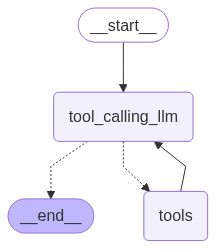

In [104]:
# Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message which is the result is a tool call -> tool_condition routes to tool, else routes to end
    tools_condition
)
builder.add_edge("tools",  "tool_calling_llm")

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

